<a href="https://colab.research.google.com/github/joshbrx/biomath_model/blob/main/full_GRN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRN model for stellate cells in pancreas.

Para modelar correctamente la red de regulación genética, renormbraremos las variables del sistema para poder simplificar el proceso

| $TNF_a$ | $TGFb_1$ | $RAS$ | $P53$ | $PIP3$ | $ERK$ | Apoptosis | Proliferation |
|:-------:|:--------:|:-----:|:-----:|:------:|:-----:|:-----------:|:---------------:|
|  $X_1$  |   $X_2$  | $Y_1$ | $Y_2$ |  $Y_3$ | $Y_4$ |    $Z_1$    |      $Z_2$      |

In [725]:
import matplotlib.pyplot as plt
import numpy as np
import random 

In [726]:
def supr(e, n, s):
    return e/(1 + s**n)

In [932]:
def dS(S, i, y1_tau1, c3_tau2):
    y1, y2, y3, y4, c2, c3, c4, c5, z1, z2, z3, z4, Ry1, Ry2, Ry3, Ry4, Rc2a, Rc2b, Rc2, Rc3, Rc4, Rc5, Rz1, Rz2, Rz3, Rz4, c2a, c2b = S
    # --------------------------------------------------------
    dRy1 = e[0]*(supr(1, n[0], X1[i]) + supr(1, n[0], y1_tau1) + supr(1, n[0], y3) + supr(1, n[0], y4)) - Ry1;    
    # dRy1 = e[0]*(supr(1, n[0], X1[i]) + supr(1, n[0], y1_tau1) + supr(1, n[0], y3) + supr(1, n[0], y4) + supr(0.059, n[0], c3_tau2)) - Ry1;    
    dy1  = supr(1, n[1], Ry1) - y1;         # 1/0.4

    # dRy2 = e[1]*(supr(1, n[0], y1) + supr(1, -n[0], y2) + supr(1, -n[0], y3)) - Ry2
    dRy2 = e[1]*(supr(1, n[0], y1) + (supr(1, -n[0], y2) * supr(1, -n[0], y3))) - Ry2
    dy2  = supr(1, n[1], Ry2) - y2;         # 1/2.14 o 1/2.1

    dRy3 = e[2]*(supr(1, n[0], X2[i]) + supr(1, n[0], y1) + supr(1, -n[0], y2)) - Ry3         
    dy3  = supr(1, n[1], Ry3) - y3;         # 1/2.14

    dRy4 = e[3]*(supr(1, n[0], X2[i]) + supr(1, n[0], y1)) - Ry4;
    dy4  = supr(1, n[1], Ry4) - y4;         # 1/0.35
    # --------------------------------------------------------
    # dRz1 = dRy2; dz1  = dy2;
    dRz2 = e[4]*(supr(1, -n[0], y2) + supr(1, n[0], y4)) - Rz2
    dz2  = supr(1, n[1], Rz2) - z2;         # 1/1.15
    # --------------------------------------------------------
    dRc2a = e[5]*(supr(2, -n[0], c2) + supr(2, -n[0], c3)) - Rc2a
    dc2a  = supr(1, n[1], Rc2a) - c2a;
    dRc2b = e[6]*(supr(2, +n[0], c2) + supr(2, -n[0], c3)) - Rc2b
    dc2b  = supr(1, n[1], Rc2b) - c2b;
    dRc2 = e[7]*(supr(2, +n[0], c2) + supr(2, -n[0], c3)) - Rc2
    dc2  = supr(1, n[1], Rc2) - c2;

    dRc3 = e[8]*(supr(1, n[0], y1_tau1) + supr(1, -n[0], c2)) - Rc3
    dc3  = supr(1, n[1], Rc3) - c3;

    dRc4 = e[9]*(supr(1, n[0], y1_tau1) + supr(1, n[0], c3) + supr(2, -n[0], c2)) - Rc4
    dc4  = supr(1, n[1], Rc4) - c4;

    dRc5 = e[10]*(supr(1, n[0], X2[i]) + supr(1, n[0], c2)) - Rc5
    dc5  = supr(1, n[1], Rc5) - c5;
    # --------------------------------------------------------
    dRz3 = e[11]*(supr(2, -n[0], c3) + supr(1, n[0], c2) + supr(1, -n[0], c4)) - Rz3
    dz3  = supr(1, n[1], Rz3) - z3;

    dRz4 = e[12]*(supr(1, n[0], y1_tau1) + supr(1, n[0], c3_tau2) + supr(1, -n[0], c5)) - Rz4
    dz4  = supr(1, n[1], Rz4) - z4;
    # --------------------------------------------------------
    dS = [dy1, dy2, dy3, dy4, dc2, dc3, dc4, dc5, dy2, dz2, dz3, dz4, dRy1, dRy2, dRy3, dRy4, dRc2a, dRc2b, dRc2, dRc3, dRc4, dRc5, dRy2, dRz2, dRz3, dRz4, dc2a, dc2b]
    return np.array(dS)

In [933]:
def RK_solver(S0, t, k1, k2):
    dims = len(S0)
    K = np.empty([4, dims])
    S = np.zeros([len(t)+1, dims])
    
    for d in range(dims):   
        S[0, d] = S0[d]

    dt = t[1] - t[0]; 
    for i in range(len(t)):
        y1_tau1, c3_tau2 = S[i-k1, 0], S[i-k2, 5]
        K[0] = dt * dS(S[i]         , i, y1_tau1, c3_tau2) 
        K[1] = dt * dS(S[i] + K[0]/2, i, y1_tau1, c3_tau2)
        K[2] = dt * dS(S[i] + K[1]/2, i, y1_tau1, c3_tau2)
        K[3] = dt * dS(S[i] + K[2]  , i, y1_tau1, c3_tau2)
        for d in range(dims):
            S[i+1, d] = S[i, d] + (K[0,d]+2*K[1,d]+2*K[2,d]+K[3,d])/6
    return S

In [934]:
# parámetros
n = [-4, -20] 
e = [1/0.4, 1/1.2, 1/2.14, 1/0.35, 1/1.15, 1/1.4, 1, 1/0.2, 2.5, 1/1.25, 1/4.25, 1/2.75, 1/1.75]
start=0; step=0.1; num=10000
t = np.arange(0,num)*step + start

<ipython-input-726-c9dcc9093113>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return e/(1 + s**n)


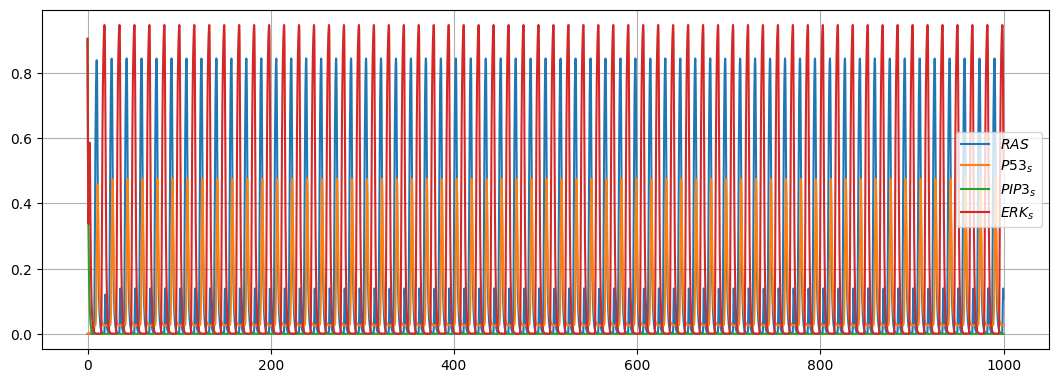

In [943]:
S0 = np.concatenate([np.array([0, 0, 1, 1]), np.zeros(8), np.zeros(16)])   # Y, C, Z, R
A = np.array([2418/941,1,1,1]);
omega = 1/5.2; X1, X2 = np.sin(t*omega)**2, np.cos(t*omega)**2          # omega_max = 7.715
# X1, X2 = np.ones(num), np.ones(num)   # labels = ["$y_1$","$y_2$","$y_3$","$y_4$","$s_2$","$s_3$","$s_4$","$s_5$","$z_1$","$z_2$","$z_3$","$z_4$"]
labels = ["$RAS$","$P53_s$","$PIP3_s$","$ERK_s$","$P53_c$","$PIP3_c$","$BCL-XL$","$P21_c$","$Apop_s$","$Prolif_s$","$Apop_c$","$Prolif_c$"]

Pip = RK_solver(S0, t, 200, 2000)
plt.figure(figsize=(13,4.5), dpi=100)
for i in range(4):
    plt.plot(t, Pip[1:,i], label=labels[i])
plt.legend(); plt.grid(); plt.show()

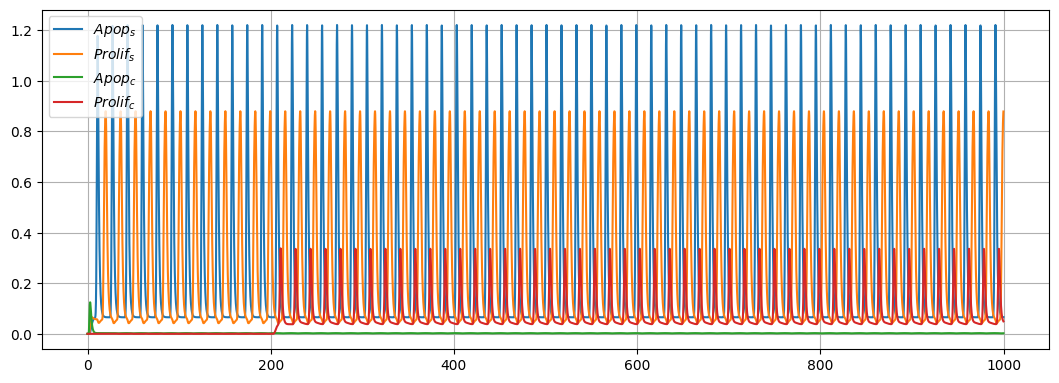

In [944]:
plt.figure(figsize=(13,4.5), dpi=100)
for i in range(4):
    plt.plot(t, Pip[1:,i+8]*A[i], label=labels[i+8])
plt.legend(); plt.grid(); plt.show()

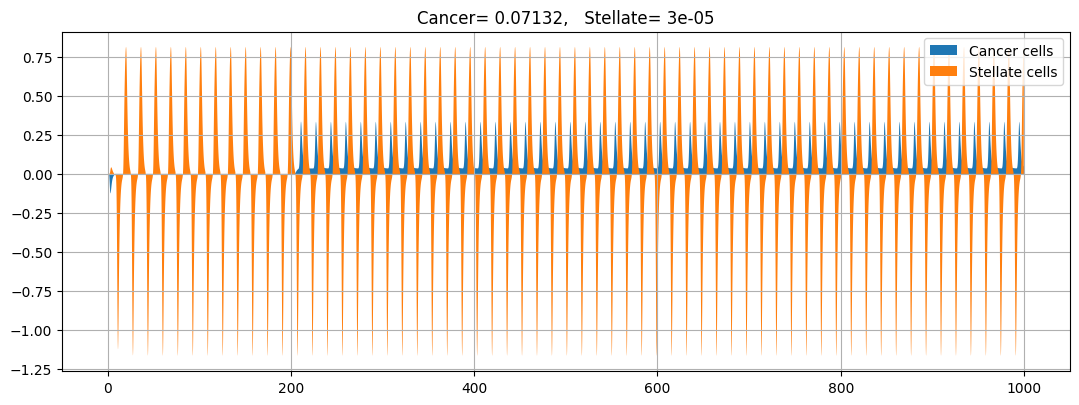

0.09410607102175604 0.24184493185836334


In [945]:
plt.figure(figsize=(13,4.5), dpi=100)

plt.fill_between(t, -A[2]*Pip[1:,10] + A[3]*Pip[1:,11], label="Cancer cells")
plt.fill_between(t, -A[0]*Pip[1:,8] + A[1]*Pip[1:,9], label="Stellate cells")
plt.grid(); plt.legend();
plt.title(f"Cancer= {round(np.mean(A[3]*Pip[:,11]), 5)},   Stellate= {round(np.mean(-A[0]*Pip[:,8] + A[1]*Pip[:,9]), 5)}"); plt.show()
print(np.mean(Pip[20:,8]), np.mean(Pip[20:,9]))

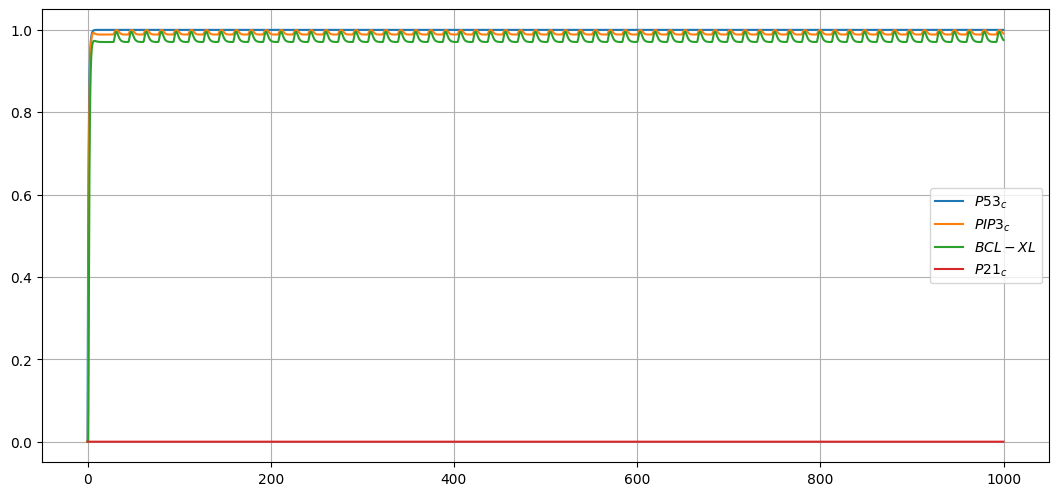

In [941]:
plt.figure(figsize=(13,6), dpi=100)
for i in range(4):
    plt.plot(t, Pip[1:,i+4], label=labels[i+4])
plt.legend(); plt.grid(); plt.show()

In [734]:
Pip[-1,:]

array([3.57365462e-01, 5.06571042e-01, 2.37217811e-05, 4.71311961e-01,
       1.00000000e+00, 9.99880962e-01, 9.97520655e-01, 1.11005142e-18,
       5.06571042e-01, 1.78912580e-02, 1.87011529e-03, 4.66541833e-01,
       5.90203592e-01, 8.98268089e-01, 5.15487026e-01, 7.25136838e-01,
       1.42929193e+00, 2.00100871e+00, 1.00050435e+01, 1.53980444e+00,
       1.29233394e+00, 1.23581301e-01, 8.98268089e-01, 8.20551350e-01,
       7.28609218e-01, 9.23095671e-01, 9.99225848e-01, 9.99999074e-01])